# ¿Pasa más tiempo la gente en una web cuando el color de fondo cambia?


https://www.kaggle.com/datasets/adarsh0806/ab-testing-practice

Una empresa quiere analizar si la modificación del color del fondo de la página web mejora el user engament de los clientes.

Para analizar esto, realizamos un A/B testing en este documento, con el objetivo de comprobar si hay una mejora significativa en las visitas a la web cuando se modifica el color de fondo de la página web. En un caso, el fondo será de color blanco (Grupo A/control), y en el otro caso será de color negro (Grupo B/test). Las hipótesis formuladas son las siguientes:

- $H_0$: la modificación del color del fondo no afecta al número de visitas.
- $H_1$: la modificación del color del fondo afecta al número de visitas.

En este caso ya tenemos a los usuarios divididos entre control (fondo blanco) y test (fondo negro). La métrica que usaremos es la tasa de conversión. 

In [2]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels as sms
from src import soporte_abtesting as sa
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import math

In [3]:
# Importamos el set de datos
df = pd.read_csv("data/ab_testing_proyecto.csv", sep = ",")
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


Las columnas en el dataset representan lo siguiente:

- User ID: identificador para cada usuario.
- Group: Contiene el identificador de grupo de control (A) y de test (B).
- Page Views: número de páginas que el usuario visitó durante el tiempo que estuvo conectado a la web.
- Time Spent: tiempo total, en segundos, que el usuario estuvo en la web.
- Conversion: indica si en usuario ha realizado una acción o no (Yes/No).
- Device: tipo de dispositivo que el usuario utilizó para acceder a la web.
- Location: región de Reino Unido donde el usuario está establecido.

In [4]:
# Creamos una copia del dataset
data = df.copy()
data.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


In [5]:
# Vemos información del dataset
info_df = sa.info_df(data)
info_df

,Tipo_dato,numero_registros,Numero_nulos,%_nulos
User ID,int64,5000,0,0.0
Group,object,5000,0,0.0
Page Views,int64,5000,0,0.0
Time Spent,int64,5000,0,0.0
Conversion,object,5000,0,0.0
Device,object,5000,0,0.0
Location,object,5000,0,0.0


In [6]:
# Revisamos que no haya duplicados
data.duplicated().sum()

np.int64(0)

In [7]:
# Vamos a ver los estadísticos de las variables numéricas del dataset
sa.estadisticos_numericas_df(data)

,count,mean,std,min,25%,50%,75%,max,Mediana,Moda,Curtosis,Coef_asimetria
User ID,5000.0,14925.16,2869.15,10001.0,12456.25,14858.5,17379.75,19995.0,14858.5,NaN,-1.18,0.04
Page Views,5000.0,7.54,4.02,1.0,4.00,8.0,11.00,14.0,8.0,NaN,-1.20,-0.02
Time Spent,5000.0,242.51,118.25,40.0,137.00,243.0,346.00,449.0,243.0,NaN,-1.22,0.00


In [8]:
# Obtenemos los estadíticos de las variables categóricas
data.describe(include = "object").T

,count,unique,top,freq
Group,5000,2,A,2519
Conversion,5000,2,No,4515
Device,5000,2,Desktop,2538
Location,5000,4,Scotland,1281


In [10]:
# Generamos la nueva columna
data["Converted"] = data["Conversion"].map({"Yes": 1, "No": 0})
data.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location,Converted
0,14292,B,3,424,No,Mobile,Northern Ireland,0
1,11682,A,9,342,No,Mobile,Scotland,0
2,19825,A,2,396,No,Desktop,Northern Ireland,0
3,16080,B,4,318,No,Desktop,Wales,0
4,18851,A,1,338,Yes,Desktop,Scotland,1


Dividimos el dataframe entre los usuarios de control y los usuarios de test.

In [11]:
# Obtenemos usuarios del grupo A (control)
usuarios_control = data[data["Group"] == "A"]
usuarios_control.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location,Converted
1,11682,A,9,342,No,Mobile,Scotland,0
2,19825,A,2,396,No,Desktop,Northern Ireland,0
4,18851,A,1,338,Yes,Desktop,Scotland,1
6,16702,A,5,106,No,Mobile,Northern Ireland,0
10,12776,A,14,351,No,Desktop,Wales,0


In [12]:
# Obtenemos usuarios del grupo B (test)
usuarios_test = data[data["Group"] == "B"]
usuarios_test.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location,Converted
0,14292,B,3,424,No,Mobile,Northern Ireland,0
3,16080,B,4,318,No,Desktop,Wales,0
5,13134,B,2,93,No,Desktop,Scotland,0
7,10041,B,9,292,No,Mobile,Northern Ireland,0
8,13191,B,8,434,No,Desktop,Northern Ireland,0


Tenemos un total de 5.000 usuarios que han entrado en la web. De estos, 2519 son parte del grupo de control, y 2481 son parte del grupo test.

Calculamos a continuación la cantidad de la muestra que necesitamos para llevar a cabo el test. Para ello tenemos que calcular la tasa de conversión de la web, por lo que vamos a generar una nueva columna numérica que se corresponda con los Yes y No de Conversion.

In [13]:
# Calculamos la tasa de conversión para el grupo de control
tasa_conversion_control = usuarios_control["Converted"].mean()
tasa_conversion_control

np.float64(0.05398967844382691)

In [15]:
# Calculamos la tasa de conversión para el grupo de test
tasa_conversion_test = usuarios_test["Converted"].mean()
tasa_conversion_test

np.float64(0.14066908504635228)

In [16]:
diferencia = proportion_effectsize(tasa_conversion_control, tasa_conversion_test)
alpha = 0.05
power = 0.80
analisis = NormalIndPower()
tamaño_muestral = analisis.solve_power(diferencia, power = power, nobs1= None, ratio = 1.0, alpha = alpha)
print(f'El tamaño muestral debe de ser de: {math.ceil(tamaño_muestral)}')

El tamaño muestral debe de ser de: 175


In [17]:
muestra_control = data[data['Group'] == 'A'].sample(n=math.ceil(tamaño_muestral), random_state=22)
muestra_test = data[data['Group'] == 'B'].sample(n=math.ceil(tamaño_muestral), random_state=22)

# unimos los dos conjuntos de datos
ab_test = pd.concat([muestra_control, muestra_test], axis=0).reset_index(drop = True)

# comprobamos que tengamos el mismo número de usuarios en los 2 grupos
ab_test["Group"].value_counts()

Group
A    175
B    175
Name: count, dtype: int64

Una vez tenemos el dataset con la muestra de la población definido, vamos a explorarlo antes de realizar el test.

In [18]:
# Vemos información sobre el dataset
sa.info_df(ab_test)

,Tipo_dato,numero_registros,Numero_nulos,%_nulos
User ID,int64,350,0,0.0
Group,object,350,0,0.0
Page Views,int64,350,0,0.0
Time Spent,int64,350,0,0.0
Conversion,object,350,0,0.0
Device,object,350,0,0.0
Location,object,350,0,0.0
Converted,int64,350,0,0.0


,mean,std
Group,,
A,0.0514,0.2215
B,0.1543,0.3623


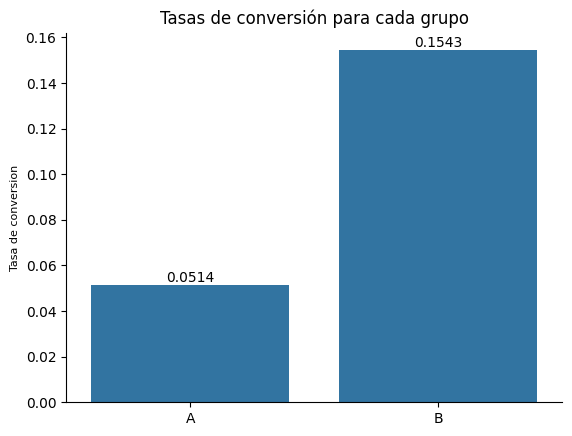

In [39]:
ratio_conversion = ab_test.groupby('Group')['Converted'].agg(["mean", "std"]).round(4)
display(ratio_conversion)

fig = sns.barplot(ratio_conversion, 
                  x = ratio_conversion.index, 
                  y = "mean") 

# ponemos las etiquetas en cada una de las barras
fig.bar_label(fig.containers[0], fontsize=10)

# eliminar los ejes de arriba y la derecha
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)

# ponemos título a la gráfica
fig.set_title("Tasas de conversión para cada grupo")

# cambiamos el nombre del eje y
fig.set_ylabel("Tasa de conversion", fontsize = 8)

# quitamos el nombre del eje x
fig.set_xlabel("");

Tasa de conversion por zona de residencia, y device

Vamos a revisar las asunciones (normalidad a través del histograma y a través de gráficos de caja y a través del test de kolmogorov-smirnof)

Antes de aplicar el test para definir si la modificación ha tenido efecto o no, vamos a comprobar la normalidad de la distribución, a través del test de Kolmogorov-Smirnov, y la homogeneidad de las varianzas a través del test de Bartlett.

Grupo de control

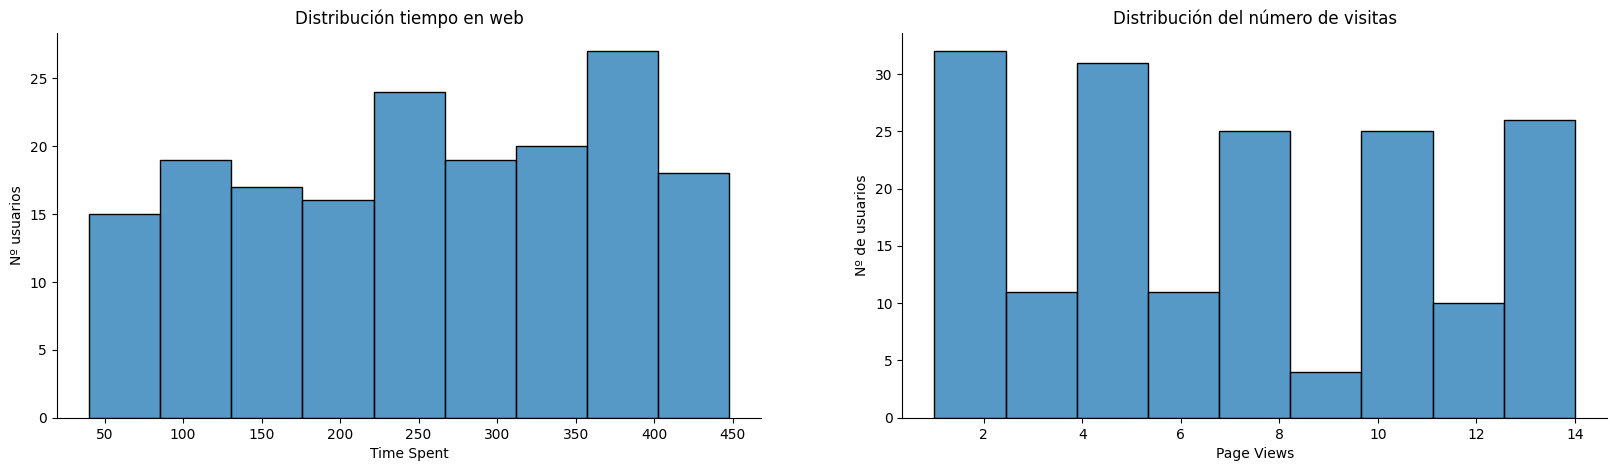

In [36]:
sa.distribucion_tiemponavegacion_nvisitas(ab_test, "A")

In [43]:
test_control = ab_test[ab_test["Group"] == "A"]


In [ ]:
estadistica_ks, p_value = stats.kstest(test_control["Converted"], 'norm')
resultado = p_value > alpha
resultado, p_value
# No rechazamos la hipótesis de normalidad

(np.False_, np.float64(5.569317971856911e-41))

Normalidad y varianzas grupo test

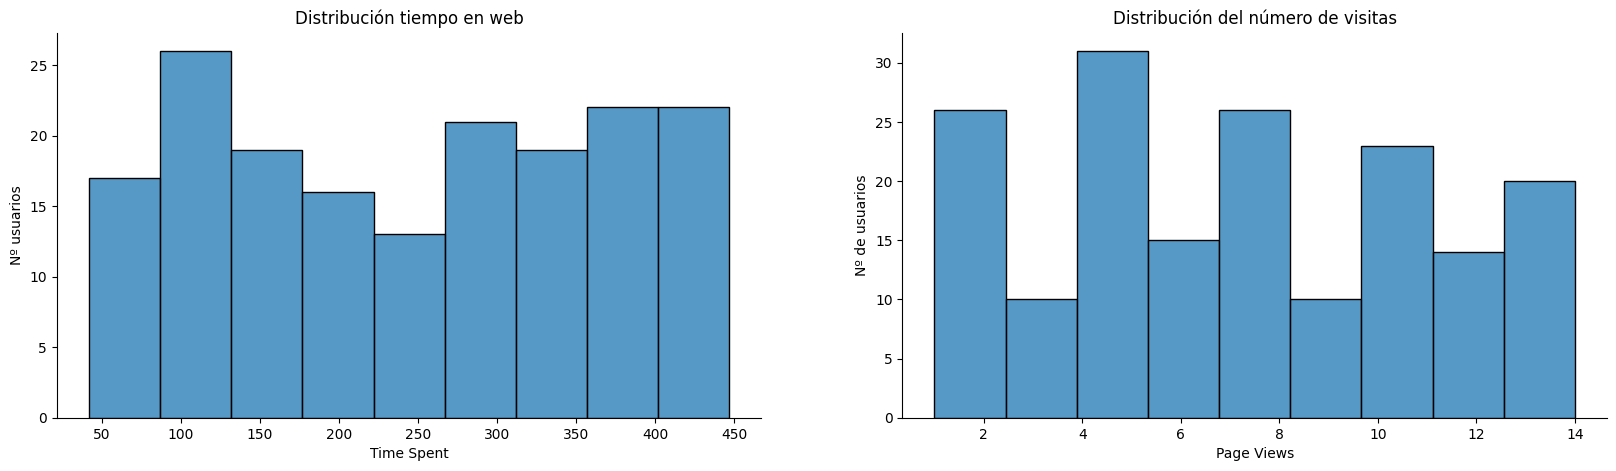

In [37]:
sa.distribucion_tiemponavegacion_nvisitas(ab_test, "B")

In [44]:
test_prueba = ab_test[ab_test["Group"] == "B"]

In [45]:
estadistica_ks, p_value = stats.kstest(test_prueba["Converted"], 'norm')
resultado = p_value > alpha
resultado, p_value
# No rechazamos la hipótesis de normalidad

(np.False_, np.float64(5.569317971856911e-41))

Calculamos las varianzas que seahomogeneas

In [ ]:
from scipy.stats import levene
statistic, p_value = levene(test_control["Converted"], ab_test[ab_test["Group"] == "B"]["Converted"])
p_value

A continuación comprobamos la asunción de homocedasticidad de las varianzas, a través del test 

A continuación aplicamos el z test para ver si no rechazamos o rechazamos la hipótesis nula 